In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
#%matplotlib qt   # doesn't work on my laptop
from tistools import read_inputfile, get_LMR_interfaces, read_pathensemble, get_weights
from tistools import set_tau_distrib, set_tau_first_hit_M_distrib, cross_dist_distr, pathlength_distr
from tistools import ACCFLAGS, REJFLAGS

from tistools import get_lmr_masks, get_generation_mask, get_flag_mask, select_with_masks
from tistools import unwrap_by_weight, running_avg_local_probs, get_local_probs, get_globall_probs, get_global_probz

from pprint import pprint    # to print the vars of the pathensemble object


In [2]:
from json import load
import numpy as np
import logging
import bisect

# Created file and added transition function
# EW - April 2024

# Hard-coded rejection flags found in output files

# logger
logger = logging.getLogger(__name__)

def get_transition_probs(pes, interfaces, weights = None, tr=False):
    """
    Returns the local crossing probabilities for the PPTIS ensemble pe.
    This is only for the [i^+-] or [0^+-'] ensembles, and NOT for [0^-'].

    Parameters
    ----------
    pes : List of PathEnsemble objects
        The PathEnsemble object must be from an [i*] simulation.
    w : array-like, optional
        The weights of the paths. If None, the weights are calculated from
        the flags. The default is None.
    tr : bool, optional
        If True, infinite time-reversal reweighting is performed.
    Returns
    -------
    p : ndarray(2, 2)
        Matrix of all local crossing probabilities from one turn to another,
        in both directions.
    """
    masks = {}
    w_path = {}

    for i, pe in enumerate(pes):
        # Get the lmr masks, weights, ACCmask, and loadmask of the paths
        masks[i] = get_lmr_masks(pe)
        if weights is None:
            w, ncycle_true = get_weights(pe.flags, ACCFLAGS, REJFLAGS, verbose = False)
            assert ncycle_true == pe.ncycle
        else:
            w = weights[i]
        accmask = get_flag_mask(pe, "ACC")
        loadmask = get_generation_mask(pe, "ld")
        msg = f"Ensemble {pe.name[-3:]} has {len(w)} paths.\n The total "+\
                    f"weight of the ensemble is {np.sum(w)}\nThe total amount of "+\
                    f"accepted paths is {np.sum(accmask)}\nThe total amount of "+\
                    f"load paths is {np.sum(loadmask)}"
        logger.debug(msg)

        w_path[i] = {}
        # l_mins = {}
        # l_maxs = {}
        # # Get the weights of the RMR, RML, LMR and LML paths
        # for pathtype in ["RMR", "RML", "LMR", "LML"]:
        #     w_path[i][pathtype] = np.sum(select_with_masks(w, [masks[i][pathtype],
        #                                                     accmask, ~loadmask]))
        #     l_mins[pathtype] = select_with_masks(pe.lambmins, [masks[i][pathtype], accmask, ~loadmask])
        #     l_maxs[pathtype] = select_with_masks(pe.lambmaxs, [masks[i][pathtype], accmask, ~loadmask])
        # msg = "Weights of the different paths:\n"+f"wRMR = {w_path[i]['RMR']}\n"+\
        #         f"wRML = {w_path[i]['RML']}\nwLMR = {w_path[i]['LMR']}\n"+\
        #         f"wLML = {w_path[i]['LML']}"
        # print(msg)
        
        # Compute indices of rows with end turn
        # w_path[i]["end"] = [0 for i in interfaces]
        # for int_i, int in enumerate(interfaces):
        #     if int_i < i:
        #         w_path[i]["end"][int_i] = np.asarray([el[0] for el in enumerate(l_mins["LML"]) if el[1] <= int and el[1] >= interfaces[int_i-1]])
        #     elif int_i > i:
        #         w_path[i]["end"][int_i] = np.asarray([el[0] for el in enumerate(l_maxs["RMR"]) if el[1] >= int and el[1] <= interfaces[int_i+1]])
            # else:
            #     w_path[i]["end"][int_i] = (w_path[i]["LML"], w_path[i]["RMR"])

        # idx_ends[i] = {}
        # for pathtype in ["RML", "LML"]:
        #     idx_ends[i][pathtype] = [0 for i in interfaces]
        #     for int_i, int in enumerate(interfaces):
        #         idx_ends[i][pathtype][int_i] = np.asarray([el[0] for el in enumerate(l_mins[pathtype]) if el[1] <= int and el[1] >= interfaces[int_i-1]])
        # for pathtype in ["RMR", "LMR"]:
        #     idx_ends[i][pathtype] = [0 for i in interfaces]
        #     for int_i, int in enumerate(interfaces):
        #         idx_ends[i][pathtype][int_i] = np.asarray([el[0] for el in enumerate(l_maxs[pathtype]) if el[1] >= int and el[1] <= interfaces[int_i+1]])

        w_path[i]["ends"] = np.empty([len(interfaces),len(interfaces)])
        for j in range(len(interfaces)):
            for k in range(len(interfaces)):
                if j == k:
                    w_path[i]["ends"][j][k] = 0  
                elif j < k:
                    dir_mask = pe.dirs == 1
                    if j == 0:
                        start_cond = pe.lambmins <= interfaces[j]
                    else: 
                        start_cond = np.logical_and(pe.lambmins <= interfaces[j], pe.lambmins >= interfaces[j-1])
                    if k == len(interfaces)-1:
                        end_cond = pe.lambmaxs >= interfaces[k]
                    else: 
                        end_cond = np.logical_and(pe.lambmaxs >= interfaces[k], pe.lambmaxs <= interfaces[k+1])
                
                    w_path[i]["ends"][j][k] = np.sum(select_with_masks(w, [start_cond, end_cond, dir_mask, accmask, ~loadmask]))
                else:
                    dir_mask = pe.dirs == -1
                    if k == 0:
                        start_cond = pe.lambmins <= interfaces[k]
                    else: 
                        start_cond = np.logical_and(pe.lambmins <= interfaces[k], pe.lambmins >= interfaces[k-1])
                    if j == len(interfaces)-1:
                        end_cond = pe.lambmaxs >= interfaces[j]
                    else: 
                        end_cond = np.logical_and(pe.lambmaxs >= interfaces[j], pe.lambmaxs <= interfaces[j+1])

                    w_path[i]["ends"][j][k] = np.sum(select_with_masks(w, [start_cond, end_cond, dir_mask, accmask, ~loadmask]))
                    

        # if tr:  # TR reweighting. Note this is not block-friendly TODO
        #     w_path[i]['RMR'] *= 2
        #     w_path[i]['LML'] *= 2
        #     temp = w_path[i]['RML'] + w_path[i]['LMR']
        #     w_path[i]['RML'] = temp
        #     w_path[i]['LMR'] = temp

    p = np.empty([len(interfaces), len(interfaces)])
    for i in range(len(interfaces)):
        for k in range(len(interfaces)):
            if i == k:
                p[i][k] = 0
            elif i < k:
                p_reachedj = np.empty(k-i+1)
                p_jtillend = np.empty(k-i+1)
                for j in range(i, k+1):
                    p_reachedj[j-i] = np.sum(w_path[i+1]["ends"][i][j:]) / np.sum(w_path[i+1]["ends"][i][i:]) if np.sum(w_path[i+1]["ends"][i][i:]) != 0 else np.nan
                    if j < len(interfaces)-1:
                        p_jtillend[j-i] = np.sum(w_path[j+1]["ends"][i][k]) / np.sum(w_path[j+1]["ends"][i][i:]) if np.sum(w_path[j+1]["ends"][i][i:]) != 0 else np.nan
                    else: p_jtillend[j-i] = 1
                print(f"i={interfaces[i]}, #j = {k-i}, k={interfaces[k]}")
                print("P_i(j reached) =", p_reachedj)
                print("P_j(k) =", p_jtillend)
                print("full P_i(k) =", p_reachedj*p_jtillend)
                p[i][k] = np.average(p_reachedj * p_jtillend)
            elif i > k:
                p_reachedj = np.empty(i-k+1)
                p_jtillend = np.empty(i-k+1)
                for j in range(k, i+1):
                    if i < len(interfaces)-1:
                        p_reachedj[j-k] = np.sum(w_path[i+1]["ends"][i][:j+1]) / np.sum(w_path[i+1]["ends"][i][:i+1]) if np.sum(w_path[i+1]["ends"][i][:i+1]) != 0 else np.nan
                        p_jtillend[j-k] = np.sum(w_path[j+1]["ends"][i][k]) / np.sum(w_path[j+1]["ends"][i][:i+1]) if np.sum(w_path[j+1]["ends"][i][:i+1]) != 0 else np.nan
                    else: 
                        p_reachedj[j-k] = 0
                        p_jtillend[j-k] = 0
                print(f"i={interfaces[i]}, #j = {k-i}, k={interfaces[k]}")
                print("P_i(j reached) =", p_reachedj)
                print("P_j(k) =", p_jtillend)
                print("full P_i(k) =", p_reachedj*p_jtillend)
                p[i][k] = np.average(p_reachedj * p_jtillend)

    msg = "Local crossing probabilities computed"
    print(msg)

    return p

In [3]:
%autoreload 2   # something with pip install -e .

UsageError: unrecognized arguments: # something with pip install -e .


# Reading

In [4]:
# zero_minus_one = True if lambda_-1 interface is set
# zero_minus_one = False if lambda_-1 interface is not set

# data the maze
#---------------
indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim_i*2/"
zero_minus_one = False
inputfile = indir + "logging.log"


import os
import glob
os.chdir(indir)
print(os.getcwd())

folders = glob.glob(indir + "/0[0-9][0-9]")
folders = sorted(folders)
print(folders)

/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim_i*2
['/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim_i*2/000', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim_i*2/001', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim_i*2/002', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim_i*2/003', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim_i*2/004', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim_i*2/005', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim_i*2/006', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim_i*2/007', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim_i*2/008', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim_i*2/009']


In [6]:
# !!! last lines !!!  allow to speed up this notebook
# pe.set_orders(load=False...)  -> 1st time you run the code, this will store npy files
# pe.set_orders(load=True...)  -> next time you run the code, you can read npy files

# Reading all input
#===================
interfaces, zero_left, timestep = read_inputfile(inputfile)
LMR_interfaces, LMR_strings = get_LMR_interfaces(interfaces, zero_left)
pathensembles = []
for i,fol in enumerate(folders):
    print("#"*80)
    print(fol)
    pe = read_pathensemble(fol+"/pathensemble.txt")
    pe.set_name(fol)
    pe.set_interfaces([LMR_interfaces[i], LMR_strings[i]])
    if i==0:
        pe.set_zero_minus_one(zero_minus_one)   # TODO this is never used
        pe.set_in_zero_minus(True)
    if i==1:
        pe.set_in_zero_plus(True)
    w, _ = get_weights(pe.flags, ACCFLAGS, REJFLAGS, verbose = False)
    pe.set_weights(w)
    print("pathensemble info: ")
    pprint(vars(pe))
    pathensembles.append(pe)
    # read order parameters order.txt/order.npy into path ensemble object
    #pe.set_orders(load=False, acc_only=True, save=False) # if saving doesn't work
    #### CHANGE HERE ####
    # pe.set_orders(load=False, acc_only=True, save=True) # for the 1st time
    pe.set_orders(load=True, acc_only=True) # for the next times, save=True/False is not important

################################################################################
/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim_i*2/000
pathensemble info: 
{'cyclenumbers': array([   0,    1,    2, ..., 1437, 1438, 1439]),
 'dirs': array([-1., -1.,  1., ...,  1.,  1.,  1.]),
 'flags': array(['ACC', 'FTL', 'ACC', ..., 'BTL', 'ACC', 'BTL'], dtype='<U3'),
 'generation': array(['ld', 'sh', 'sh', ..., 'sh', 'sh', 'sh'], dtype='<U2'),
 'has_zero_minus_one': False,
 'in_zero_minus': True,
 'in_zero_plus': False,
 'interfaces': [[-1.0, -1.0, -1.0], ['l_[0]', 'l_[0]', 'l_[0]']],
 'lambmaxs': array([-0.999     , -0.99990392, -0.99738613, ..., -1.10345343,
       -0.99643329, -1.00440563]),
 'lambmins': array([-1.1       , -2.25642865, -1.11353083, ..., -1.57472973,
       -1.32188812, -1.57028654]),
 'lengths': array([ 499, 1056,   93, ...,  178,  230,  812]),
 'lmrs': array(['RMR', 'RM*', 'RMR', ..., '*M*', 'RMR', '*M*'], dtype='<U3'),
 'name': '/mnt/0bf0c339-34bb-4500-a5fb-

# Analysis

In [7]:
# Setting path ensemble properties
#==================================
for i,fol in enumerate(folders):
    print(i)
    if i != 1:
        print("Calculating path lengths.")
        set_tau_distrib(pathensembles[i])
        print("Done.")
    #else:
        #TODO problem with ...
    if i > 1:
        print("Calculating first hitting lengths to middle interface")
        set_tau_first_hit_M_distrib(pathensembles[i])
        print("Done.")
    #else:
        # TODO problem with ....

0
Calculating path lengths.
Done.
1
2
Calculating path lengths.
Done.
Calculating first hitting lengths to middle interface
NOT LAST
Done.
3
Calculating path lengths.
Done.
Calculating first hitting lengths to middle interface
NOT LAST
Done.
4
Calculating path lengths.
Done.
Calculating first hitting lengths to middle interface
NOT LAST
Done.
5
Calculating path lengths.
Done.
Calculating first hitting lengths to middle interface
NOT LAST
Done.
6
Calculating path lengths.
Done.
Calculating first hitting lengths to middle interface
NOT LAST
Done.
7
Calculating path lengths.
Done.
Calculating first hitting lengths to middle interface
NOT LAST
Done.
8
Calculating path lengths.
Done.
Calculating first hitting lengths to middle interface
NOT LAST
Done.
9
Calculating path lengths.
Done.
Calculating first hitting lengths to middle interface
NOT LAST
Done.


In [9]:
# Analyze the [i*] simulation.
# Analysis output is saved to the data dictionary.
data = {}

data["running"] = {}

for i, pe in enumerate(pathensembles):
    print("doing pathensemble {}".format(i))
    if i == 0:
        data[i] = {}
        continue  # TODO: make [0-] analysis ???

    # analysis using all data: ["full"]
    data[i] = {}
    data[i]["full"] = get_transition_probs(pathensembles, interfaces)


# for i, pe in enumerate(pathensembles):
#     print("doing pathensemble {}".format(i))
#     if i == 0:
#         data[i] = {}
#         continue  # TODO: make [0-] analysis ???

    # masks - TODO not used further on?
    # TODO these functions are duplicate in repptis_analysis
    #masks = get_lmr_masks(pe)
    #loadmask = get_generation_mask(pe, "ld")
    #print("Amount of loads: {}".format(np.sum(loadmask)))
    ##hardloadmask = get_hard_load_mask(loadmask)
    #accmask = get_flag_mask(pe, "ACC")

    # pathtype_cycles
    # pathtypes = ("LML", "LMR", "RML", "RMR")
    # pathtype_cycles = {}
    # for ptype in pathtypes:
    #     pathtype_cycles[ptype] = unwrap_by_weight(
    #             (pe.lmrs == ptype).astype(int), pe.weights)
    
    # # running average analysis: ["running"]
    # data[i] = {}
    # data[i]["running"] = {}
    # data[i]["running"]["plocal"] = {}
    # # you'll still have to hardload select pe.weigths... TODO. # this is comment wouter?
    # for (ptype, p_loc) in zip(pathtypes, 
    #                           running_avg_local_probs(pathtype_cycles, 
    #                                                   pe.weights, tr = False)):
    #     data[i]["running"]["plocal"][ptype] = p_loc

    # analysis using all data: ["full"]
    plocfull = get_local_probs(pe, tr=False)
    data[i]["full"] = {}
    for ptype in pathtypes:
        data[i]["full"][ptype] = plocfull[ptype]

    # data[i] have now ["full"] and ["running"]

doing pathensemble 0
doing pathensemble 1
i=-1.0, #j = 1, k=-0.75
P_i(j reached) = [1. 1.]
P_j(k) = [0.21710526 0.36166667]
full P_i(k) = [0.21710526 0.36166667]
i=-1.0, #j = 2, k=-0.5
P_i(j reached) = [1.         1.         0.78289474]
P_j(k) = [0.36842105 0.24333333 0.32283465]
full P_i(k) = [0.36842105 0.24333333 0.25274554]
i=-1.0, #j = 3, k=-0.25
P_i(j reached) = [1.         1.         0.78289474 0.41447368]
P_j(k) = [0.13157895 0.13666667 0.2808399  0.35146444]
full P_i(k) = [0.13157895 0.13666667 0.21986808 0.14567276]
i=-1.0, #j = 4, k=0.0
P_i(j reached) = [1.         1.         0.78289474 0.41447368 0.28289474]
P_j(k) = [0.10855263 0.08833333 0.16535433 0.29288703 0.27102804]
full P_i(k) = [0.10855263 0.08833333 0.12945504 0.12139397 0.07667241]
i=-1.0, #j = 5, k=0.25
P_i(j reached) = [1.         1.         0.78289474 0.41447368 0.28289474 0.17434211]
P_j(k) = [0.05921053 0.06833333 0.09186352 0.12970711 0.25233645 0.19672131]
full P_i(k) = [0.05921053 0.06833333 0.07191946 0.

In [6]:

for i, pe in enumerate(pathensembles):
    upe = pe.unify_pe()
    # Pathlength distribution
    data[i]["pathlengths"] = pathlength_distr(upe)  # these might be used later or not! TODO
        
#=======================================
# make figures
makefigs = True 
if makefigs:
    for i, pe in enumerate(pathensembles):     
        if i == 0:
            continue
        # Cross distances distribution
        L, M, R, lmlpercs, lmllambs, rmrpercs, rmrlambs = cross_dist_distr(pe)
        fig,ax = plt.subplots()
        ax.plot(lmllambs, lmlpercs, lw=1, c="g")
        ax.plot(rmrlambs, rmrpercs, lw=1, c="r")
        for lamb in (L,M,R):
            ax.axvline(lamb, color='k', linestyle='--', lw = 0.5)
        ax.set_xlabel('Cross distance')
        ax.set_ylabel('Frequency')
        ax.set_title("Ensemble {}. L = {}, M = {}, R = {}".format(
            pe.name, L, M, R))
        ax.set_ylim(0)
        fig.savefig(f"pathensemble_{i}_crossdist.pdf")
        plt.close(fig)

        # Pathlength distribution      
        for ptype in pathtypes:
            fig, ax = plt.subplots()
            ax.plot(data[i]["pathlengths"][ptype]["bin_centers"], 
                data[i]["pathlengths"][ptype]["hist"])
            ax.set_xlabel('Pathlength')
            ax.set_ylabel('Frequency')
            ax.set_title(f"{np.sum(data[i]['pathlengths'][ptype]['hist'])} " + \
                         f"{ptype} paths. ")
            ax.legend([f"mean = {data[i]['pathlengths'][ptype]['mean']:.2f}, " + \
                          f"std = {data[i]['pathlengths'][ptype]['std']:.2f}"])
            fig.savefig(f"pathensemble_{i}_pathlength_{ptype}.pdf")
            plt.close(fig)

Are all weights 1?  True
Are all paths accepted?  True


/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NameError: name 'data' is not defined

# Pcross with recursive relations

In [94]:
# Global crossing probabilities
# WITHOUT ERRORS #  
# Full data 
psfull = []
for i in range(1, len(pathensembles)):   # do not use the 0- ensemble
    psfull.append({"LMR": data[i]["full"]["LMR"], 
               "RML": data[i]["full"]["RML"], 
               "RMR": data[i]["full"]["RMR"],
               "LML": data[i]["full"]["LML"]})

Pminfull, Pplusfull, Pcrossfull = get_globall_probs(psfull)
print(Pcrossfull)

[1.0, 0.0879754507431392, 0.00398119031819352, 0.0023694052311736395, 0.0012275742258149962, 0.0007212630249327627, 0.000507828487072553]


This should be the same as the repptis_report.pdf value: 0.000507828487072553
which is the case!
Here, the load immediately disappeared. For a simulation where this is
not the case, the above code should be adapted a little bit.


/tmp/ipykernel_16014/3779179883.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


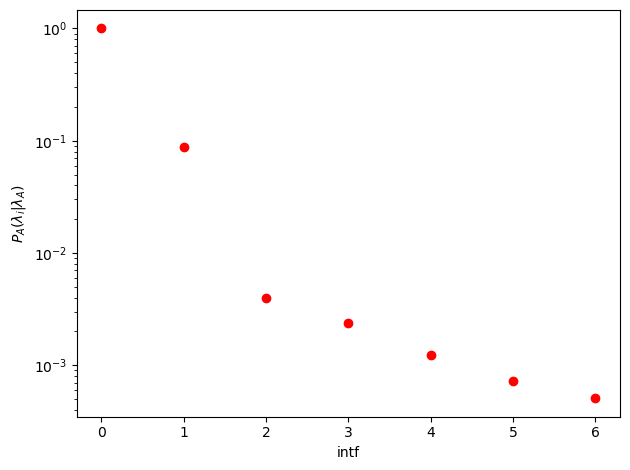

In [95]:
# Make a figure of the global crossing probabilities
fig, ax = plt.subplots()
ax.set_yscale("log")
ax.plot(Pcrossfull, "o", c = "r")

# cosdip meta
# ax.errorbar([i for i in range(7)], Pcrossfull, yerr=[0, 0.004830, Pcrossfull[2]*0.05068988646, Pcrossfull[3]*0.05189862680, Pcrossfull[4]*0.05071184896, Pcrossfull[5]*0.05083284286, Pcrossfull[6]*0.05067963543], fmt="-o", c = "b", ecolor="r", capsize=6)

# cosbump meta
# ax.errorbar([i for i in range(7)], Pcrossfull, yerr=[0, 0.002535, Pcrossfull[2]*0.04393065503, Pcrossfull[3]*0.04910273500, Pcrossfull[4]*0.05239942040, Pcrossfull[5]*0.05789033634, Pcrossfull[6]*0.0614468], fmt="-o", c = "b", ecolor="r", capsize=6)

# 2 cosdips
# ax.errorbar([i for i in range(5)], Pcrossfull, yerr=[0, 0.007239, Pcrossfull[2]*0.0414296, Pcrossfull[3]*0.0445266, Pcrossfull[4]*0.0483538], fmt="-o", c = "b", ecolor="r", capsize=6)

# 3 cosbumps
# ax.errorbar([i for i in range(7)], Pcrossfull, yerr=[0, 0.002295, Pcrossfull[2]*0.0328798, Pcrossfull[3]*0.031594, Pcrossfull[4]*0.031474, Pcrossfull[5]*0.03080392, Pcrossfull[6]*0.0308589], fmt="-o", c = "b", ecolor="r", capsize=6)

# 2 cosbumps
#ax.errorbar([i for i in range(5)], Pcrossfull, yerr=[0, 0.002768, Pcrossfull[2]*0.04440278, Pcrossfull[3]*0.043053, Pcrossfull[4]*0.0463156], fmt="-o", c = "b", ecolor="r", capsize=6)

# flat dt=0.00002 30k cycles
# ax.errorbar([i for i in range(5)], Pcrossfull, yerr=[0, 0.003294, Pcrossfull[2]*0.07640968, Pcrossfull[3]*0.07789262, Pcrossfull[4]*0.0812692], fmt="-o", c = "b", ecolor="r", capsize=6)

# flat 100k cycles
#ax.errorbar([i for i in range(5)], Pcrossfull, yerr=[0, 0.002741, Pcrossfull[2]*0.034092, Pcrossfull[3]*0.033621, Pcrossfull[4]*0.0398], fmt="-o", c = "b", ecolor="r", capsize=6)
ax.set_xlabel("intf")
ax.set_ylabel(r"$P_A(\lambda_i|\lambda_A)$")
ax.set_xticks(np.arange(len(interfaces)))
fig.tight_layout()
fig.show()
fig.savefig("Global_probs.pdf")

print("This should be the same as the repptis_report.pdf value:", Pcrossfull[-1])
print("which is the case!")
print("Here, the load immediately disappeared. For a simulation where this is")
print("not the case, the above code should be adapted a little bit.")

In [96]:
# TODO I am not sure what this is

# Construct lists of the local probs

# Or we can use the get_global_probz function, using lists of the local probs
# These do not use the 0- ensemble
pmps = [data[i]["full"]["LMR"] for i in range(1,len(pathensembles))]
pmms = [data[i]["full"]["LML"] for i in range(1,len(pathensembles))]
ppps = [data[i]["full"]["RMR"] for i in range(1,len(pathensembles))]
ppms = [data[i]["full"]["RML"] for i in range(1,len(pathensembles))]
a,b,c = get_global_probz(pmps, pmms, ppps, ppms)
print("This should be the same as the repptis_report.pdf value:", c[-1])

This should be the same as the repptis_report.pdf value: 0.000507828487072553


# Now work with MSM

In [97]:
from tistools import construct_M
from tistools import global_cross_prob
from tistools import vector_G

In [98]:
def create_labels_states(N):
    assert N>=3
    labels1 = ["0-     ","B      "]
    labels2 = ["0+- LML","0+- LMR","0+- RML","1+- LML","1+- LMR"]
    if N>3:
        for i in range(1,N-2):
            labels2.append(str(i)  +"+- RML")
            labels2.append(str(i)  +"+- RMR")
            labels2.append(str(i+1)+"+- LML")
            labels2.append(str(i+1)+"+- LMR")
    return labels1, labels2

def print_vector(g, states=None):
    if states is None:
        for i in range(len(g)):
            print("state", i, g[i])
    else:
        for i in range(len(g)):
            print("state", states[i], g[i][0])

In [99]:
print(interfaces)
N = len(interfaces)
assert N >= 4
NS = 4*N-5
print("N", N)
print("len pmms", len(pmms))
print("NS", NS)

#labels2 = ["0+- LML","0+- LMR","0+- RML","1+- LML","1+- LMR",
#           "1+- RML", "1+- RMR", "2+- LML", "2+- LMR",
#           "2+- RML", "2+- RMR", "3+- LML", "3+- LMR",]
labels1, labels2 = create_labels_states(N)

[0.2, 0.325, 0.55, 0.62, 0.69, 0.75, 0.8]
N 7
len pmms 6
NS 23


In [100]:
print("mm", pmms)
print("mp", pmps)
print("pm", ppms)
print("pp", ppps)
print("sum", np.array(pmms)+np.array(pmps))
print("sum", np.array(ppms)+np.array(ppps))
M = construct_M(pmms, pmps, ppms, ppps, NS, N)

#Local crossing probabilities:
#pRMR = 0.34205627942625644.  #ppps
#pRML = 0.6579437205737436.   #ppms
#pLMR = 0.25316455696202533.  #pmps
#pLML = 0.7468354430379747.   #pmms

mm [0.9120245492568608, 0.9547465766351416, 0.41390253116735926, 0.7099874234470691, 0.5682710965970941, 0.4393149494672337]
mp [0.0879754507431392, 0.045253423364858346, 0.5860974688326407, 0.2900125765529309, 0.431728903402906, 0.5606850505327663]
pm [1.0, 0.9632511889321228, 0.3884401691682561, 0.7857196066746126, 0.7390544342173545, 0.44611310560551665]
pp [0.0, 0.03674881106787722, 0.6115598308317439, 0.21428039332538737, 0.2609455657826455, 0.5538868943944834]
sum [1. 1. 1. 1. 1. 1.]
sum [1. 1. 1. 1. 1. 1.]


In [101]:
print("M")
print("shape", M.shape)
print("sum prob in rows", np.sum(M,axis=1))
print(M)
# row 8, 10, 12, 14. # counting starts from 0   not okay!!!!

M
shape (23, 23)
sum prob in rows [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[0.         0.91202455 0.08797545 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.95474658 0.04525342
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.     

# Look at this Markov model

In [102]:
#import numpy.linalg
vals, vecs = np.linalg.eig(M)
print(vals)
vals, vecs = np.linalg.eig(M.T)
print(vals)

[ 1.00000000e+00+0.00000000e+00j  8.19239778e-01+0.00000000e+00j
 -1.00000000e+00+0.00000000e+00j -8.19239778e-01+0.00000000e+00j
  1.96470150e-01+1.83954187e-01j  1.96470150e-01-1.83954187e-01j
 -1.96470150e-01+1.83954187e-01j -1.96470150e-01-1.83954187e-01j
 -3.54729390e-17+2.87162741e-01j -3.54729390e-17-2.87162741e-01j
 -1.56323207e-15+1.93060217e-02j -1.56323207e-15-1.93060217e-02j
 -1.08214236e-16+1.64982897e-08j -1.08214236e-16-1.64982897e-08j
  2.66830457e-15+0.00000000e+00j  9.53130503e-16+0.00000000e+00j
 -1.28744424e-16+0.00000000e+00j  5.86951839e-17+0.00000000e+00j
 -1.07782998e-18+3.41584937e-18j -1.07782998e-18-3.41584937e-18j
 -3.35480346e-32+0.00000000e+00j  7.67432186e-32+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j]
[ 1.00000000e+00+0.00000000e+00j -1.00000000e+00+0.00000000e+00j
  8.19239778e-01+0.00000000e+00j -8.19239778e-01+0.00000000e+00j
  0.00000000e+00+2.87162741e-01j  0.00000000e+00-2.87162741e-01j
  1.96470150e-01+1.83954187e-01j  1.96470150e-01-1.83954

In [103]:
print("what if chain propagates")
print("A[0,:]")
# check stationary behavior
A = M
for n in range(10):
    A = np.dot(A,M)
    #print(A)
    print(A[0,:])
    print(np.sum(A[0,:]))  # is 1 indeed

what if chain propagates
A[0,:]
[0.91202455 0.         0.         0.         0.08399426 0.00398119
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
1.0
[0.         0.83178878 0.08023577 0.08399426 0.         0.
 0.         0.         0.00164782 0.00233337 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
1.0
[9.15783039e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.66048275e-02 3.63094331e-03 1.58726915e-03 6.05556004e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.65666021e-03 6.76705361e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
1.0
[0.00000000e+00 8.35216613e-01 8.05664256e-02 7.81920967e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.527

# Pcross with MSM

In [104]:
# global crossing prob
z1, z2, y1, y2 = global_cross_prob(M)
print("Z")
print_vector(z1, labels1)
print_vector(z2, labels2)
print("Y")
print_vector(y1, labels1)
print_vector(y2, labels2)
print("global crossing prob", y1[0])

Z
state 0-      0
state B       1
state 0+- LML 0.0
state 0+- LMR 0.005772388578664443
state 0+- RML 0.0
state 1+- LML 0.0
state 1+- LMR 0.12755694816995888
state 1+- RML 0.0
state 1+- RMR 0.12755694816995888
state 2+- LML 0.004687566188692826
state 2+- LMR 0.2143274102678544
state 2+- RML 0.004687566188692826
state 2+- RMR 0.2143274102678544
state 3+- LML 0.13289487376933806
state 3+- LMR 0.41368454663945203
state 3+- RML 0.13289487376933803
state 3+- RMR 0.41368454663945203
state 4+- LML 0.19306259531365288
state 4+- LMR 0.7040822411767103
state 4+- RML 0.1930625953136529
state 4+- RMR 0.7040822411767103
state 5+- LML 0.32641090592943556
state 5+- LMR 1.0
Y
state 0-      0.000507828487072553
state B       0.0
state 0+- LML 0.0
state 0+- LMR 0.005772388578664443
state 0+- RML 0.0
state 1+- LML 0.0
state 1+- LMR 0.12755694816995888
state 1+- RML 0.0
state 1+- RMR 0.12755694816995888
state 2+- LML 0.004687566188692826
state 2+- LMR 0.2143274102678544
state 2+- RML 0.004687566188692826
s

# Collecting times

In [105]:
#TODO I need data too?

In [106]:
def collect_tau(pathensembles, data):
    # pathensembles -- list of pathensemble instances
    
    print("Collect tau")
    
    # average path lengths
    taumm = np.zeros(len(pathensembles))
    taump = np.zeros(len(pathensembles))
    taupm = np.zeros(len(pathensembles))
    taupp = np.zeros(len(pathensembles))
    
    # for [1+-] and higher (i>=2)
    for i in range(2,len(pathensembles)):
        print("ensemble", i, pathensembles[i].name)
        taumm[i] = pathensembles[i].tauavg['LML']-2
        taump[i] = pathensembles[i].tauavg['LMR']-2
        taupm[i] = pathensembles[i].tauavg['RML']-2
        taupp[i] = pathensembles[i].tauavg['RMR']-2

    # for [0-] (i=0)
    print("ensemble", 0, pathensembles[0].name)
    if pe.has_zero_minus_one:
        # TODO pieces missing
        taumm[0] = pathensembles[0].tauavg['LML']-2
        taump[0] = pathensembles[0].tauavg['LMR']-2
        taupm[0] = pathensembles[0].tauavg['RML']-2
        taupp[0] = pathensembles[0].tauavg['RMR']-2
    else:
        taupp[0] = pathensembles[0].tauavg['RMR']-2

    # for [0+-] (i=1)
    print("ensemble", 1, pathensembles[1].name)
    taumm[1] = data[1]["pathlengths"]["LML"]["mean"] - 2
    taump[1] = data[1]["pathlengths"]["LMR"]["mean"] - 2
    taupm[1] = data[1]["pathlengths"]["RML"]["mean"] - 2
    #taupp[1] = data[1]["pathlengths"]["RMR"]["mean"] - 2

    return taumm, taump, taupm, taupp

# this is the same:
# 1) after:
#   data[2]["pathlengths"] = pathlength_distr(upe)  # use correct upe!
#   This gives the whole distrib, mean, std, etc
#   print(data[2]["pathlengths"]["RMR"]["mean"])
# 2) after:
#   set_tau_distrib(pathensembles[2])
#   print(pathensembles[2].tauavg['RMR'])

# TODO for [0-]
# likely not okay yet, what about L*L etc??????
# There are paths missing TODO!!!!!!!! when lambda-1

In [107]:
# TODO fix +-1 issues!!!!!!
# TODO tau1 is not fool proof if you have too many phase points!!

def collect_tau1(pathensembles, data):
    # average path lengths, but only the part before the 1st crossing
    #---------------------------
    print("Collect tau1")
    taumm1 = np.zeros(len(pathensembles))
    taump1 = np.zeros(len(pathensembles))
    taupm1 = np.zeros(len(pathensembles))
    taupp1 = np.zeros(len(pathensembles))
    
    # for [1+-] and higher (i>=2)
    for i in range(2,len(pathensembles)):
        taumm1[i] = pathensembles[i].tau1avg['LML'] - 1
        taump1[i] = pathensembles[i].tau1avg['LMR'] - 1
        taupm1[i] = pathensembles[i].tau1avg['RML'] - 1
        taupp1[i] = pathensembles[i].tau1avg['RMR'] - 1
    # for [0-] (i=0) -> just 0
    # for [0+-] (i=1) LML -> just 0
    # for [0+-] (i=1) LMR -> just 0
    # for [0+-] (i=1) RML
    taupm1[1] = data[1]["pathlengths"]["RML"]["mean"] - 2
    
    return taumm1, taump1, taupm1, taupp1

def collect_tau2(pathensembles, data):
    # average path lengths, but only the part after the last crossing
    #---------------------------
    print("Collect tau2")
    taumm2 = np.zeros(len(pathensembles))
    taump2 = np.zeros(len(pathensembles))
    taupm2 = np.zeros(len(pathensembles))
    taupp2 = np.zeros(len(pathensembles))
    
    # for [1+-] and higher (i>=2)
    for i in range(2,len(pathensembles)):
        taumm2[i] = pathensembles[i].tau2avg['LML'] - 1
        taump2[i] = pathensembles[i].tau2avg['LMR'] - 1
        taupm2[i] = pathensembles[i].tau2avg['RML'] - 1
        taupp2[i] = pathensembles[i].tau2avg['RMR'] - 1
    # for [0-] (i=0) -> just 0
    # for [0+-] (i=1) LML -> just 0
    # for [0+-] (i=1) LMR
    taump2[1] = data[1]["pathlengths"]["LMR"]["mean"] - 2
    # for [0+-] (i=1) RML -> just 0
    
    return taumm2, taump2, taupm2, taupp2

def collect_taum(pathensembles, data):
    # average path lengths, but only the part between first/last crossing
    #---------------------------
    print("Collect taum")
    taumm_m = np.zeros(len(pathensembles))
    taump_m = np.zeros(len(pathensembles))
    taupm_m = np.zeros(len(pathensembles))
    taupp_m = np.zeros(len(pathensembles))
    
    # for [1+-] and higher (i>=2)
    for i in range(2,len(pathensembles)):
        #print("ensemble", i, pathensembles[i].name)
        taumm_m[i] = pathensembles[i].tauavg['LML'] \
                   - pathensembles[i].tau1avg['LML'] \
                   - pathensembles[i].tau2avg['LML']
        taump_m[i] = pathensembles[i].tauavg['LMR'] \
                   - pathensembles[i].tau1avg['LMR'] \
                   - pathensembles[i].tau2avg['LMR']
        taupm_m[i] = pathensembles[i].tauavg['RML'] \
                   - pathensembles[i].tau1avg['RML'] \
                   - pathensembles[i].tau2avg['RML']
        taupp_m[i] = pathensembles[i].tauavg['RMR'] \
                   - pathensembles[i].tau1avg['RMR'] \
                   - pathensembles[i].tau2avg['RMR']

    # for [0-] (i=0)
    if pe.has_zero_minus_one:
        # TODO there are more paths!!!
        taumm_m[0] = pathensembles[0].tauavg['LML']-2
        taump_m[0] = pathensembles[0].tauavg['LMR']-2
        taupm_m[0] = pathensembles[0].tauavg['RML']-2
        taupp_m[0] = pathensembles[0].tauavg['RMR']-2
    else:
        taupp_m[0] = pathensembles[0].tauavg['RMR']-2

    # for [0+-] (i=1) LML
    taumm_m[1] = data[1]["pathlengths"]["LML"]["mean"] - 2
    # for [0+-] (i=1) LMR -> just 0
    # for [0+-] (i=1) RML -> just 0

    return taumm_m, taump_m, taupm_m, taupp_m


In [108]:
def print_all_tau(pathensembles, taumm, taump, taupm, taupp):
    # print all tau
    print(f"                  mm            mp            pm            pp")
    for i in range(len(pathensembles)):
        print(f"{i} {pathensembles[i].name[-3:]}  {taumm[i]:13.1f} {taump[i]:13.1f} {taupm[i]:13.1f} {taupp[i]:13.1f}")

In [109]:
taumm, taump, taupm, taupp = collect_tau(pathensembles, data)
taumm1, taump1, taupm1, taupp1 = collect_tau1(pathensembles, data)
taumm2, taump2, taupm2, taupp2 = collect_tau2(pathensembles, data)
taumm_m, taump_m, taupm_m, taupp_m = collect_taum(pathensembles, data)

Collect tau
ensemble 2 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/2D-experiments/2D-maze/Wouter-2022/repptis3/002
ensemble 3 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/2D-experiments/2D-maze/Wouter-2022/repptis3/003
ensemble 4 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/2D-experiments/2D-maze/Wouter-2022/repptis3/004
ensemble 5 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/2D-experiments/2D-maze/Wouter-2022/repptis3/005
ensemble 6 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/2D-experiments/2D-maze/Wouter-2022/repptis3/006
ensemble 0 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/2D-experiments/2D-maze/Wouter-2022/repptis3/000
ensemble 1 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/2D-experiments/2D-maze/Wouter-2022/repptis3/001
Collect tau1
Collect tau2
Collect taum


In [110]:
print("tau")
print_all_tau(pathensembles, taumm, taump, taupm, taupp)
print("\ntau1")
print_all_tau(pathensembles, taumm1, taump1, taupm1, taupp1)
print("\ntau_m")
print_all_tau(pathensembles, taumm_m, taump_m, taupm_m, taupp_m)
print("\ntau2")
print_all_tau(pathensembles, taumm2, taump2, taupm2, taupp2)

tau
                  mm            mp            pm            pp
0 000            0.0           0.0           0.0         122.6
1 001           41.0         132.9         129.9           0.0
2 002          558.3         690.8         697.8         849.9
3 003          857.0         578.4         574.5         468.0
4 004          220.2         169.6         170.6         196.5
5 005          174.1         139.2         137.9         163.1
6 006          144.0         114.5         112.1         141.0

tau1
                  mm            mp            pm            pp
0 000            0.0           0.0           0.0           0.0
1 001            0.0           0.0         129.9           0.0
2 002          135.1         133.9         330.5         305.8
3 003          338.2         321.8          54.6          55.0
4 004           54.1          53.4          55.7          54.6
5 005           55.7          54.7          41.4          42.9
6 006           43.1          41.4          3

In [111]:
def construct_tau_vector(N, NS, taumm, taump, taupm, taupp):
    assert N>=4
    assert NS==4*N-5
    assert len(taumm) == N
    assert len(taump) == N
    assert len(taupm) == N
    assert len(taupp) == N
    # unravel the values into one vector
    tau = np.zeros(NS)
    # [0-]
    tau[0] = taupp[0]
    # [0+-]
    tau[1] = taumm[1]
    tau[2] = taump[1]
    tau[3] = taupm[1]
    # [1+-] etc
    for i in range(1,N-2):
        tau[4*i]   = taumm[i+1]
        tau[4*i+1] = taump[i+1]
        tau[4*i+2] = taupm[i+1]
        tau[4*i+3] = taupp[i+1]
    # [(N-2)^(-1)]
    tau[-3] = taumm[-1]
    tau[-2] = taump[-1]
    # B
    tau[-1] = 0.   # whatever
    return tau

In [112]:
tau  = construct_tau_vector(N, NS, taumm, taump, taupm, taupp)
tau1 = construct_tau_vector(N, NS, taumm1, taump1, taupm1, taupp1)
taum = construct_tau_vector(N, NS, taumm_m, taump_m, taupm_m, taupp_m)
tau2 = construct_tau_vector(N, NS, taumm2, taump2, taupm2, taupp2)
tau_m = tau-tau1-tau2  # yes, this is the same thing

print("tau")
print(tau)
print("\n")
print("tau1")
print(tau1)
print("taum")
print(taum)
print("tau2")
print(tau2)

print("\n")
print("tau = tau1+taum+tau2 => difference is", np.sum((tau-tau1-taum-tau2)**2))

tau
[122.59844936  40.95532539 132.88517875 129.89168347 558.25282787
 690.82414272 697.81777379 849.92352941 856.95789217 578.36564823
 574.48554716 467.97282638 220.24115756 169.63737921 170.64555582
 196.52998436 174.06787707 139.15997954 137.86758565 163.07190705
 143.97923281 114.52065576   0.        ]


tau1
[  0.           0.           0.         129.89168347 135.14434756
 133.93721038 330.54241472 305.82352941 338.18297432 321.83558936
  54.5684215   55.03888919  54.0726072   53.40919161  55.68400095
  54.62489136  55.68876489  54.74841044  41.44391884  42.92442956
  43.0765107   41.36328045   0.        ]
taum
[122.59844936  40.95532539   0.           0.         288.43468998
 226.48540315 229.43087971 234.05882353 185.48679567 201.91053242
 197.16673071 358.40817378 111.97281322  61.35465473  61.10836691
  86.63045368  63.11268427  42.23540159  41.92135703  76.86215198
  57.6097434   38.96362302   0.        ]
tau2
[  0.           0.         132.88517875   0.         134.6737903

# Compute tau for [0+]

In [113]:
g1, g2, h1, h2 = vector_G(M, tau1, tau_m, tau2) #, doprint=True)
print("G")
print_vector(g1, labels1)
print_vector(g2, labels2)
print("H")
print_vector(h1, labels1)
print_vector(h2, labels2)
print("interesting")
print(h1[0])

G
state 0-      0.0
state B       0.0
state 0+- LML 40.95532539064838
state 0+- LMR 634.4580991219331
state 0+- RML 0.0
state 1+- LML 423.1084803092534
state 1+- LMR 2156.9980787004515
state 1+- RML 367.2753590664273
state 1+- RMR 2144.211146355688
state 2+- LML 951.3505544465012
state 2+- LMR 2058.2664283562713
state 2+- RML 952.4927622497322
state 2+- RMR 2214.670306676231
state 3+- LML 1890.558398157917
state 3+- LMR 1584.2888227866179
state 3+- RML 1839.3514026696503
state 3+- RMR 1609.9657281784657
state 4+- LML 1908.5776623010288
state 4+- LMR 888.2220093777526
state 4+- RML 1886.622216918643
state 4+- RMR 923.9579177737457
state 5+- LML 1736.3219588347583
state 5+- LMR 73.15737531095795
H
state 0-      93.1689994269615
state B       0.0
state 0+- LML 0.0
state 0+- LMR 634.4580991219332
state 0+- RML 0.0
state 1+- LML 134.6737903314371
state 1+- LMR 1930.5126755493857
state 1+- RML 137.84447935368044
state 1+- RMR 1910.1523228262758
state 2+- LML 765.8637587789826
state 2+- LMR 1

In [114]:
print(h1[0])

[93.16899943]


# Flux

In [115]:
flux = 1/(tau[0]+h1[0])
# dt = 0.0002
# dt = 0.00002
dt = 0.01
flux
print(flux/dt, "1/time")

[0.46346194] 1/time
